<a href="https://colab.research.google.com/github/thenaivekid/Human-action-recognition/blob/main/inference_har_finetuned_vid_mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Our model link: https://huggingface.co/thenaivekid/videomae-base-finetuned-ucf101-subset



### training code: https://www.kaggle.com/code/ashokneupane/har-finetuing-video-mae




In [24]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
model_name = "thenaivekid/videomae-base-finetuned-ucf101-subset"
model = VideoMAEForVideoClassification.from_pretrained(model_name)
image_processor = VideoMAEImageProcessor.from_pretrained(model_name)


In [59]:
!pip install -q pytorchvideo

In [ ]:
!cp /usr/local/lib/python3.11/dist-packages/pytorchvideo/transforms/augmentations.py .
with open('augmentations.py', 'r') as file:
    lines = file.readlines()

# Make changes to the file (example: replace some text)
lines = [line.replace('import torchvision.transforms.functional_tensor as F_t', 'import torchvision.transforms.functional as F_t') for line in lines]

# Save the modified file
with open('augmentations.py', 'w') as file:
    file.writelines(lines)

!cp ./augmentations.py /usr/local/lib/python3.11/dist-packages/pytorchvideo/transforms/


In [ ]:
import pytorchvideo.data#import torchvision.transforms.functional as F_t should should replace
#----> 9 import torchvision.transforms.functional_tensor as F_t



from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [25]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps



val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

In [40]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

def display_gif_from_path(path):
    video = EncodedVideo.from_path(path)
    clip_duration = video.duration

    # Sample a clip from the video
    clip = video.get_clip(start_sec=0, end_sec=clip_duration)
    clip = val_transform(clip)
    return display_gif(clip["video"])



In [58]:
import torch
from pytorchvideo.data.encoded_video import EncodedVideo
from torchvision.transforms import Compose

def predict_video_label(file_path, model, val_transform, id2label):
    """
    Predicts the label of a video using the provided model.

    Args:
        file_path (str): Path to the video file.
        model (torch.nn.Module): Pre-trained model for video classification.
        val_transform (torchvision.transforms.Compose): Transformations to apply to the video.
        id2label (dict): Dictionary mapping class IDs to labels.

    Returns:
        str: Predicted label for the video.
    """
    # Check for CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Load the video
    video = EncodedVideo.from_path(file_path)
    clip_duration = video.duration

    # Sample a clip from the video
    clip = video.get_clip(start_sec=0, end_sec=clip_duration)

    # Apply the transformations
    transformed_clip = val_transform(clip)
    transformed_clip = transformed_clip["video"].unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        output = model(transformed_clip.permute(0, 2, 1, 3, 4))  # Permute to (B, C, T, H, W)
        pred_id = torch.argmax(output.logits, dim=1).item()

    return id2label[pred_id]


In [53]:
%%bash
gdown --fuzzy "https://drive.google.com/file/d/1yghjmipX8hTn4wa5qGyvuL_55MU9yds7/view?usp=drive_link"
gdown --fuzzy "https://drive.google.com/file/d/1gtbr59r2nFEAaC8MQoJxq2qnv18IKdiT/view?usp=drive_link"
gdown --fuzzy "https://drive.google.com/file/d/1I_bzOzuEuym5nvEYs-5i_mSFg7-CKlUx/view?usp=drive_link"
gdown --fuzzy "https://drive.google.com/file/d/1m-FWAlwhOz7qxW7w4USroNxesENORdYj/view?usp=drive_link"
gdown --fuzzy "https://drive.google.com/file/d/16TmWG7lZm8TGy16VR-bp6c32i8KnfnaC/view?usp=drive_link"


Downloading...
From: https://drive.google.com/uc?id=1yghjmipX8hTn4wa5qGyvuL_55MU9yds7
To: /content/v_BenchPress_g05_c02.avi
100%|██████████| 235k/235k [00:00<00:00, 5.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gtbr59r2nFEAaC8MQoJxq2qnv18IKdiT
To: /content/v_BaseballPitch_g20_c04.avi
100%|██████████| 268k/268k [00:00<00:00, 6.34MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I_bzOzuEuym5nvEYs-5i_mSFg7-CKlUx
To: /content/v_BandMarching_g05_c06.avi
100%|██████████| 369k/369k [00:00<00:00, 29.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1m-FWAlwhOz7qxW7w4USroNxesENORdYj
To: /content/v_BalanceBeam_g11_c04.avi
100%|██████████| 267k/267k [00:00<00:00, 6.17MB/s]
Downloading...
From: https://drive.google.com/uc?id=16TmWG7lZm8TGy16VR-bp6c32i8KnfnaC
To: /content/v_BabyCrawling_g04_c01.avi
100%|██████████| 227k/227k [00:00<00:00, 5.74MB/s]


predicted action:  BenchPress


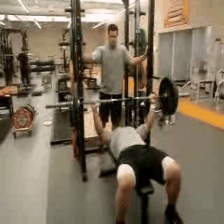

In [54]:
file_paths = [
    "/content/v_BenchPress_g05_c02.avi",
    "/content/v_BaseballPitch_g20_c04.avi",
    "/content/v_BandMarching_g05_c06.avi",
    "/content/v_BalanceBeam_g11_c04.avi",
    "/content/v_BabyCrawling_g04_c01.avi"
]
video_path = file_paths[0]
print("predicted action: ",predict_video_label(video_path, model, val_transform, model.config.id2label))
display_gif_from_path(video_path)

In [57]:
print("trained on following classes")
model.config.id2label

trained on following classes


{0: 'ApplyEyeMakeup',
 1: 'ApplyLipstick',
 2: 'Archery',
 3: 'BabyCrawling',
 4: 'BalanceBeam',
 5: 'BandMarching',
 6: 'BaseballPitch',
 7: 'Basketball',
 8: 'BasketballDunk',
 9: 'BenchPress'}